# Generative Adverserial Networks & Semi-Supervised Learning
### By Jakub Langr (originally written March 2017)
This code was written for me to experiment with some of the recent advancements in AI. I chose specificially semi-supervised learning and Generative Adverserial Networks (GANs) to push myself. Some of the code was done as a homework for the [Creative Applications of Deep Learning Course](https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow-iv), which was extremely helpful in helping me learn about modern AI. Some of the broad framework came as pre-coded set-up and explanations for the last part of the course by [Parag Mital](https://www.linkedin.com/in/pkmital), but this usage of his code is completely novel and took a lot of engineering, stitching together and abstractions.
In this Jupyter Notebook I do the following things:
1. Import all the necessary dependencies (as well as some that I just used during development but not in final version)
2. Use a GAN approach to generate synethic images. 
    + More specifically, [this recently extremely popular unsupervised technique](http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/) can learn the higher representations of what constitutes a human face (along with many attributes in the latent space) on the [Celeb Dataset](mmlab.ie.cuhk.edu.hk/projects/CelebA.html) by competing another network to fool each other (explained later)
    + Alternatively, one can think of this approach as using an auto-encoder-style gene generative model that tries to generate new examples based on a seeding factor.
3. This seeding factor or 'latent feature space' invariably encode some aspects of the generative models and once understood, can be used to predictiably manipulate the nature of generated images--e.g. baldness, gender or smile. 
4. We can therefore generate an almost infinite supply of new examples and because we know how we manipulate the latent space, we can know their labels. In this example, we created 40,000 of Men and Women faces that can now be used for further training
5. Then we train the next layer classifier on the synthetic data for a binary classification of men or women faces.  Instead of training a new classifier from scratch, however, we use a `transfer learning` approach using Oxford's `Visual Geometry Group` or `vgg16` pre-trained network to get higher accuracy without having to traing for days on a massive cluster.
6. We use the different `vgg16` Celebrity face predictions (`2623` to be exact) and train a simple fully connected two-layer neural network on the synthetic examples with the labels. (This is in stead of the typical transfer learning approach that cuts off the last layer and trains on those. Here we simply split that into 2 steps)
7. Use the 100 hand-labelled (by me) examples to evalute the accuracy of the new classifier.

### Motivation
This is really exciting because it allow us to train classifier with having virtually no labelled data as long as we have lots of unlabelled data, [which is a tremendously promising strategy especially for smaller companies with smaller datasets](http://jakublangr.com/ai-2016-review.html).


### Brief definition of terms:
**Semi-supervised learning**: is basically using unlabelled data in addition labelled data during the traing process

**Generative Adverserial Netwokrs**: explained in detail below

The code was done in `Tensorflow 1.0.0`.

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import pandas as pd
    import pickle
    import tflearn
    import pickle
    from joblib import Parallel, delayed
    import random
    import multiprocessing
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, datasets, dataset_utils, nb_utils
except ImportError as e:
    print(e)
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.")
    print(e)

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="part-1---generative-adversarial-networks-gan--deep-convolutional-gan-dcgan"></a>
# Generative Adversarial Networks (GAN) / Deep Convolutional GAN (DCGAN)

<a name="introduction"></a>
## Introduction

Recall that a Generative Adversarial Network is two networks, a generator and a discriminator.  The "generator" takes a feature vector and decodes this feature vector to become an image. The discriminator is exactly like the encoder of the Autoencoder, except it can only have 1 value in the final layer.  We use a sigmoid to squash this value between 0 and 1, and then interpret the meaning of it as: 1, the image you gave me was real, or 0, the image you gave me was generated by the generator, it's a FAKE! So the discriminator is like an encoder which takes an image and then perfoms lie detection.  Are you feeding me lies?  Or is the image real?  

Consider the AutoEncoders for instance.  The loss function operated partly on the input space.  It said, per pixel, what is the difference between my reconstruction and the input image?  The l2-loss per pixel.  Recall at that time we suggested that this wasn't the best idea because per-pixel differences aren't representative of our own perception of the image.  One way to consider this is if we had the same image, and translated it by a few pixels.  We would not be able to tell the difference, but the per-pixel difference between the two images could be enormously high.

The GAN does not use per-pixel difference.  Instead, it trains a distance function: the discriminator.  The discriminator takes in two images, the real image and the generated one, and learns what a similar image should look like!  That is really the amazing part of this network and has opened up some very exciting potential future directions for unsupervised learning.  Another network that also learns a distance function is known as the siamese network.  We didn't get into this network in this course, but it is commonly used in facial verification, or asserting whether two faces are the same or not.

The GAN network is notoriously a huge pain to train!  For that reason, we won't actually be training it.  Instead, we'll discuss an extension to this basic network called the VAEGAN (Variational Auto Encoder GAN). For now, let's stick with creating the GAN.

Let's first create the two networks: the discriminator and the generator.  We'll first begin by building a general purpose encoder which we'll use for our discriminator.  What we want is for the input placeholder to be encoded using a list of dimensions for each of our encoder's layers.  In the case of a convolutional network, our list of dimensions should correspond to the number of output filters.  We also need to specify the kernel heights and widths for each layer's convolutional network.

We'll first need a placeholder.  This will be the "real" image input to the discriminator and the discrimintator will encode this image into a single value, 0 or 1, saying, yes this is real, or no, this is not real.

This description was kindly provided by Parag under [MIT License](http://jakublangr.com/ai-2016-review.html).

In [4]:
tf.reset_default_graph()

In [5]:
from libs import celeb_vaegan as CV

In [5]:
net = CV.get_celeb_vaegan_model()

We'll load the graph_def contained inside this dictionary.  It follows the same idea as the `inception`, `vgg16`, and `i2v` pretrained networks.  It is a dictionary with the key `graph_def` defined, with the graph's pretrained network.  It also includes `labels` and a `preprocess` key.  We'll have to do one additional thing which is to turn off the random sampling from variational layer.  This isn't really necessary but will ensure we get the same results each time we use the network.  We'll use the `input_map` argument to do this.  Don't worry if this doesn't make any sense, as we didn't cover the variational layer in any depth.  Just know that this is removing a random process from the network so that it is completely deterministic.  If we hadn't done this, we'd get slightly different results each time we used the network (which may even be desirable for your purposes).

In [6]:
sess = tf.Session()
g = tf.get_default_graph()
tf.import_graph_def(net['graph_def'], name='net', input_map={
        'encoder/variational/random_normal:0': np.zeros(512, dtype=np.float32)})
names = [op.name for op in g.get_operations()]
print(names)

['net/_inputs/Const', 'net/x', 'net/encoder/0/conv2d/W', 'net/encoder/0/conv2d/W/read', 'net/encoder/0/conv2d/conv', 'net/encoder/0/conv2d/b', 'net/encoder/0/conv2d/b/read', 'net/encoder/0/conv2d/h', 'net/encoder/0/Elu', 'net/encoder/1/conv2d/W', 'net/encoder/1/conv2d/W/read', 'net/encoder/1/conv2d/conv', 'net/encoder/1/conv2d/b', 'net/encoder/1/conv2d/b/read', 'net/encoder/1/conv2d/h', 'net/encoder/1/Elu', 'net/encoder/2/conv2d/W', 'net/encoder/2/conv2d/W/read', 'net/encoder/2/conv2d/conv', 'net/encoder/2/conv2d/b', 'net/encoder/2/conv2d/b/read', 'net/encoder/2/conv2d/h', 'net/encoder/2/Elu', 'net/encoder/3/conv2d/W', 'net/encoder/3/conv2d/W/read', 'net/encoder/3/conv2d/conv', 'net/encoder/3/conv2d/b', 'net/encoder/3/conv2d/b/read', 'net/encoder/3/conv2d/h', 'net/encoder/3/Elu', 'net/encoder/4/conv2d/W', 'net/encoder/4/conv2d/W/read', 'net/encoder/4/conv2d/conv', 'net/encoder/4/conv2d/b', 'net/encoder/4/conv2d/b/read', 'net/encoder/4/conv2d/h', 'net/encoder/4/Elu', 'net/encoder/flatte

Now let's get the relevant parts of the network: `X`, the input image to the network, `Z`, the input image's encoding, and `G`, the decoded image.  In many ways, this is just like the Autoencoders we learned about above, except instead of `Y` being the output, we have `G` from our generator!  And the way we train it is very different: we use an adversarial process between the generator and discriminator, and use the discriminator's own distance measure to help train the network, rather than pixel-to-pixel differences.

In [7]:
X = g.get_tensor_by_name('net/x:0')
Z = g.get_tensor_by_name('net/encoder/variational/z:0')
G = g.get_tensor_by_name('net/generator/x_tilde:0')

Let's get some data to play with:

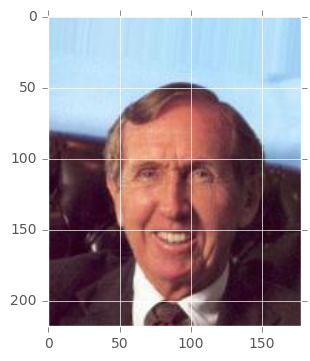

In [7]:
files = sorted(datasets.CELEB())
img_i = 20
img = plt.imread(files[img_i])
plt.imshow(img)

Now preprocess the image, and see what the generated image looks like (i.e. the lossy version of the image through the network's encoding and decoding).

In [9]:
p = CV.preprocess(img)
synth = sess.run(G, feed_dict={X: p[np.newaxis]})

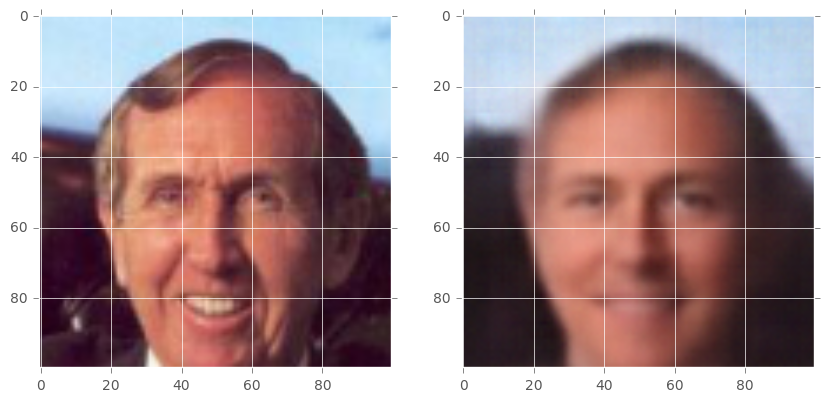

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(p)
axs[1].imshow(synth[0] / synth.max())

So we lost a lot of details but it seems to be able to express quite a bit about the image.  Our inner most layer, `Z`, is only 512 values yet our dataset was 200k images of 64 x 64 x 3 pixels (about 2.3 GB of information).  That means we're able to express our nearly 2.3 GB of information with only 512 values!  Having some loss of detail is certainly expected!

<a name="exploring-the-celeb-net-attributes"></a>
## Exploring the Celeb Net Attributes

Let's now try and explore the attributes of our dataset.  We didn't train the network with any supervised labels, but the Celeb Net dataset has 40 attributes for each of its 200k images.  These are already parsed and stored for you in the `net` dictionary:

In [11]:
net.keys()

dict_keys(['attributes', 'labels', 'graph_def', 'preprocess'])

In [12]:
len(net['labels'])

40

In [13]:
net['labels']

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

Let's see what attributes exist for one of the celeb images:

['Big_Nose',
 'Gray_Hair',
 'Male',
 'Mouth_Slightly_Open',
 'No_Beard',
 'Smiling',
 'Straight_Hair',
 'Wearing_Necktie']

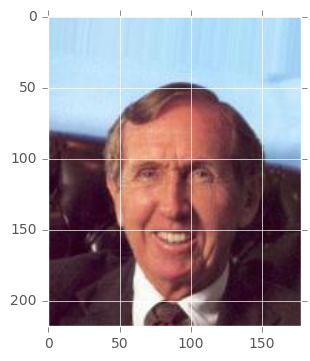

In [14]:
plt.imshow(img)
[net['labels'][i] for i, attr_i in enumerate(net['attributes'][img_i]) if attr_i]

<a name="find-the-latent-encoding-for-an-attribute"></a>
## Find the Latent Encoding for an Attribute

The Celeb Dataset includes attributes for each of its 200k+ images.  This allows us to feed into the encoder some images that we know have a *specific* attribute, e.g. "smiling".  We store what their encoding is and retain this distribution of encoded values.  We can then look at any other image and see how it is encoded, and slightly change the encoding by adding the encoded of our smiling images to it!  The result should be our image but with more smiling.  That is just insane and we're going to see how to do it.  First lets inspect our latent space:

<a name="latent-feature-arithmetic"></a>
## Latent Feature Arithmetic

Let's now try to write a general function for performing everything we've just done so that we can do this with many different features.  We'll then try to combine them and synthesize people with the features we want them to have...

In [15]:
def get_features_for(label='Bald', has_label=True, n_imgs=50):
    # Helper function to obtain labels and then preprocessing and returning
    # a vector for the seeding function for GAN
    # basically figures out the embedding for a particular attribute
    label_i = net['labels'].index(label)
    label_idxs = np.where(net['attributes'][:, label_i] == has_label)[0]
    label_idxs = np.random.permutation(label_idxs)[:n_imgs]
    imgs = [plt.imread(files[img_i])[..., :3]
            for img_i in label_idxs]
    preprocessed = np.array([CV.preprocess(img_i) for img_i in imgs])
    zs = sess.run(Z, feed_dict={X: preprocessed})
    return np.mean(zs, 0)

Let's try getting some attributes positive and negative features. 

In [16]:
# Explore different attributes
z1 = get_features_for('Male', True, n_imgs=10)
z2 = get_features_for('Male', False, n_imgs=10)
z3 = get_features_for('Smiling', True, n_imgs=10)
z4 = get_features_for('Smiling', False, n_imgs=10)

In [17]:
b1 = sess.run(G, feed_dict={Z: z1[np.newaxis]})
b2 = sess.run(G, feed_dict={Z: z2[np.newaxis]})
b3 = sess.run(G, feed_dict={Z: z3[np.newaxis]})
b4 = sess.run(G, feed_dict={Z: z4[np.newaxis]})

In [18]:
#plt.imshow(b1)
#b1.shape
z1.shape

(512,)

Here we just sense-check that this code is correct. Using the latent attributes we talked about and seeing what they look like.

(<matplotlib.image.AxesImage at 0x7f4df242ee80>,
 None,
 (-0.5, 99.5, 99.5, -0.5))

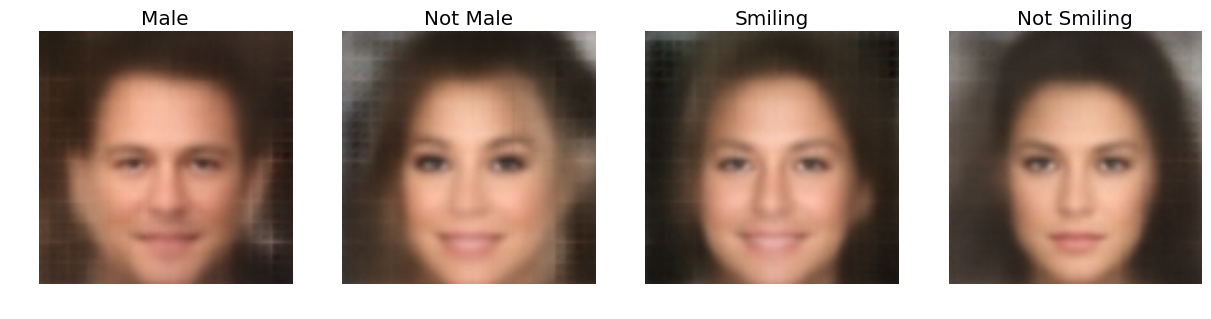

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(b1[0] / b1.max()), axs[0].set_title('Male'), axs[0].grid('off'), axs[0].axis('off')
axs[1].imshow(b2[0] / b2.max()), axs[1].set_title('Not Male'), axs[1].grid('off'), axs[1].axis('off')
axs[2].imshow(b3[0] / b3.max()), axs[2].set_title('Smiling'), axs[2].grid('off'), axs[2].axis('off')
axs[3].imshow(b4[0] / b4.max()), axs[3].set_title('Not Smiling'), axs[3].grid('off'), axs[3].axis('off')

Looks good enough.

Now we use the code to create an interpolation between "Male" and "Not Male" (Female) images. Because we are only using the two endpoints, we get two images: a 100% Man and 100% Woman (please note that we can also get anything in between by doing a weighed average of the two seeding vectors).

In [20]:
def gan_generate_data(num_iter=20000,imgs=15):
    # generates 2*(number of iter) images 
    # adding random number of pictures for each synthesis (to increase variation)
    # returns list of [Male, Female] * num_iter images
    generated_images = []
    
    for i in range(num_iter):

        n_imgs = random.choice(range(imgs-10, imgs+10))

        z1 = get_features_for('Male', True, n_imgs=n_imgs)
        z2 = get_features_for('Male', False, n_imgs=n_imgs)

        notmale_vector = z2 - z1
        amt = np.linspace(0, 1, 2)
        zs = np.array([z1 + notmale_vector*amt_i for amt_i in amt])
        g = sess.run(G, feed_dict={Z: zs})
        
        generated_images.append(g[0])
        generated_images.append(g[1])
        
        if i%1000==0:
            print('Iteration number : {}'.format(i))
        
    return generated_images

generated_data = gan_generate_data()
    

Iteration number : 0


KeyboardInterrupt: 

We just now save to a pickle for reuse and do some data cleaning as well as some plots just to show off the data.

In [ ]:
# pickle.dump( generated_data, open( "save.p", "wb" ) )
# generated_data = pickle.load(pickle.load(open("save.p.pkl")))

In [21]:
with open('save.p', 'rb') as pickle_file:
    generated_data = pickle.load(pickle_file)

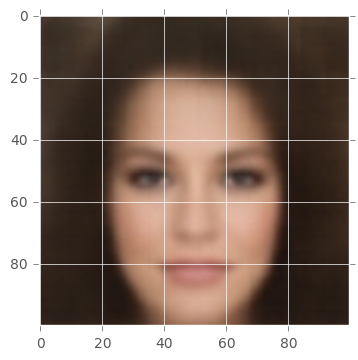

In [59]:
# Just to test out an image and how it looks like
plt.imshow(generated_data[3])

Okay good, we have the data to play around with and it's saved in a pickle file so we don't have to re-create it. Now, let's just add one hot encoded labels (we have done this in predictable manner -- i.e. male (0) is always first). We can just sense-check it and get the shape of the overall sample.

In [ ]:
labels = [0,1] * 20000

In [ ]:
plt.imshow(imgs[0][1])

In [37]:
generated_data = np.array(generated_data)
generated_data.shape

(40000, 100, 100, 3)

<a name="extensions"></a>
## Extensions
Now let's get to the transfer learning part. First we have to get out network, `vgg16`.

In [9]:
from libs import vgg16, inception, i2v

In [13]:
# SO: g = sess.run(feed_dict = {X : img, y = (Male or Female)})
# out = sess.run(feed_dict={X: img, y : Male})

# sess.close()
tf.reset_default_graph()

# Stick w/ VGG for now, and then after you see how
# the next few sections work w/ this network, come back
# and explore the something else.

net = vgg16.get_vgg_face_model()

In [14]:
# Let's explicity use the CPU, since we don't gain anything using the GPU
# when doing Deep Dream (it's only a single image, benefits come w/ many images).
device = '/cpu:0'

# We'll now explicitly create a graph
g = tf.Graph()

In [15]:
# And here is a context manager.  We use the python "with" notation to create a context
# and create a session that only exists within this indent,  as soon as we leave it,
# the session is automatically closed!  We also tel the session which graph to use.
# We can pass a second context after the comma,
# which we'll use to be explicit about using the CPU instead of a GPU.
with tf.Session(graph=g) as sess, g.device(device):
    
    # Now load the graph_def, which defines operations and their values into `g`
    tf.import_graph_def(net['graph_def'], name='net')

In [16]:
names = [op.name for op in g.get_operations()]

In [17]:
print(names)

['net/Placeholder', 'net/conv1_1/weights', 'net/conv1_1/weights/read', 'net/conv1_1/biases', 'net/conv1_1/biases/read', 'net/conv1_1/Conv2D', 'net/conv1_1/BiasAdd', 'net/conv1_1/conv1_1', 'net/conv1_2/weights', 'net/conv1_2/weights/read', 'net/conv1_2/biases', 'net/conv1_2/biases/read', 'net/conv1_2/Conv2D', 'net/conv1_2/BiasAdd', 'net/conv1_2/conv1_2', 'net/pool1', 'net/conv2_1/weights', 'net/conv2_1/weights/read', 'net/conv2_1/biases', 'net/conv2_1/biases/read', 'net/conv2_1/Conv2D', 'net/conv2_1/BiasAdd', 'net/conv2_1/conv2_1', 'net/conv2_2/weights', 'net/conv2_2/weights/read', 'net/conv2_2/biases', 'net/conv2_2/biases/read', 'net/conv2_2/Conv2D', 'net/conv2_2/BiasAdd', 'net/conv2_2/conv2_2', 'net/pool2', 'net/conv3_1/weights', 'net/conv3_1/weights/read', 'net/conv3_1/biases', 'net/conv3_1/biases/read', 'net/conv3_1/Conv2D', 'net/conv3_1/BiasAdd', 'net/conv3_1/conv3_1', 'net/conv3_2/weights', 'net/conv3_2/weights/read', 'net/conv3_2/biases', 'net/conv3_2/biases/read', 'net/conv3_2/C

## Transfer Learning
Here we get the `vgg16` network, which we have loaded up earlier and use it to generate the predictions for one of its own pre-trained classes. However, since we want to predict a different task, we then use the `transferred_predictions` function to get the predictions for the 2623 different classes and then use that as an input to the next classifier to train it on recognizing gender. 


In order to do this effectively we must first do some image processing, which we do in `transferred_df`.

In [18]:
def transferred_predictions(img):
    # gets an image (`np.array`) as an input outputs net's final layer predictions 
    results = []
    
    # Grab the tensor defining the input to the network
    x = g.get_tensor_by_name(names[0] + ":0")

    # And grab the tensor defining the softmax layer of the network
    softmax = g.get_tensor_by_name(names[-2] + ":0")
    
    with tf.Session(graph=g) as sess, g.device('/cpu:0'):
        # Remember from the lecture that we have to set the dropout
        # "keep probability" to 1.0.
        res = softmax.eval(feed_dict={x: img } ) # , Not using droput here
                    # 'net/dropout_1/random_uniform:0': [[1.0] * 4096],
                    # 'net/dropout/random_uniform:0': [[1.0] * 4096]})
        test_array = res.argsort()[-5:][::-1].flatten()
        results = ([(res.flatten()[int(idx)], 
                net['labels'][int(idx)])
               for idx in test_array ])

        result = pd.DataFrame(results, columns=['score','label']) # .sort(columns='score')
        
        results.append(result.score)
    
    return results

In [19]:
def transferred_df(generated_data):
    # does the preprocessing of the `list` of generated_data and outputs `list` of predictions
    results = []
    
    for i in range(len(generated_data)):
        img = imresize(generated_data[i], size=(224,224,3))
        img = net['preprocess'](img)[np.newaxis]
        result = transferred_predictions(img)
        results.append(result)
        
        if i%1000==0:
            print("Current image id {}".format(i))
        
    return results

In [29]:
def parallel_transfer_eval(generated_data):
    # returns parallely executed `transferred_df` using first split (fs), second (ss) and third (ts) as divisors
    pool = multiprocessing.Pool(4)
    fs = int(len(generated_data)/4)
    ss = int(2*len(generated_data)/4)
    ts = int(3*len(generated_data)/4)
    target = generated_data[:fs], generated_data[fs:ss], generated_data[ss:ts],generated_data[ts:]
    results = pool.map(transferred_df, zip(target))
    # results = Parallel(n_jobs=4)(delayed(transferred_df)(img) for img in generated_data)

    return results

In [57]:
# results = parallel_transfer_eval(generated_data[:20000])
results = transferred_df(generated_data[:20000])

Current image id 0
Current image id 1000
Current image id 2000
Current image id 3000
Current image id 4000
Current image id 5000
Current image id 6000
Current image id 7000
Current image id 8000
Current image id 9000
Current image id 10000
Current image id 11000
Current image id 12000
Current image id 13000
Current image id 14000
Current image id 15000
Current image id 16000
Current image id 17000
Current image id 18000
Current image id 19000


In [61]:
# just some data transformation
array = np.array([ [res[0] for res in result] for result in results ])
array.shape

(20000, 2623)

In [3]:
# save for later reuse
# pickle.dump(array, open('transferred_pred.pkl', 'wb'))
with open('transferred_pred.pkl', 'rb') as pickle_file:
    array = pickle.load(pickle_file)
    
array.shape

(20000, 2623)

In [ ]:
# img = imresize(imgs[0][0], (224,224,3))

## Leveraging transfer learning
Now we use the predictions made by `vgg16` in a typical [Transfer Learning](http://cs231n.github.io/transfer-learning/) paradigm. Here we just take the last layer of predictions, reshape the features and feed it to a next layer classifier (sometimes also done by removing the last (few) Fully Connected Layers) and putting training the whole network. Here we just create a new one just on the last layer. The practice supports both approaches. 

In [ ]:
from sklearn.cross_validation import train_test_split

# train-test for proper evaluation
train_X, test_X, train_y, test_y = train_test_split(X, y )

tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)

# set up the network
net = tflearn.input_data(shape=[None, 2623])
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

# train
model = tflearn.DNN(net)
model.fit(generated_data, labels, validation_set=train_X)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# reshape labels so that they match what the network expects
labels = ['Male', 'Female'] * 10000
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)
labels = np_utils.to_categorical(labels)
labels.shape

(20000, 2)

In [8]:
test_imgs = np.array([CV.preprocess(plt.imread(file)) for file in files[:100]])
test_imgs.shape

(100, 100, 100, 3)

In [20]:
test_array = transferred_df(test_imgs)

Current image id 0


And we're done with this bit as we have scores for both generated and hand-labelled images (test)! This only is the first step, however, in our journey, as now we have to transfer the `vgg16` generated scores onto the new classifier (the last bit in transfer learning, which is typically simplified by cutting off the last layer and just re-running the network with a new final layer, but here done explicitly for training purposes.)

## Training and evaluating a new classifier 
For simplicity, we will just use the `tflearn` classifier so that we have an easier job using transfer learning given the complexity of all the previous work:
1. we train (based on the synthetic data and the therefore completely predictable labels)
2. we evalute on the handlablled examples (by me) 

In [69]:
#import gc
#gc.collect()

745

In [32]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


labels = [0,1] * 10000

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=2623)]


classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[2623,512],
                                            gradient_clip_norm=.01,
                                            optimizer=tf.train.AdamOptimizer(learning_rate=0.1),
                                            n_classes=2)
                                            # model_dir='./model')

# Fit model.
classifier.fit(x=array,
               y=labels,
               batch_size=256,
               steps=10000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_is_chief': True, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe22fd2eba8>, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_master': ''}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y 

/opt/conda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpccmgwa1k/model.ckpt.
INFO:tensorflow:step = 1, loss = 1.09312
INFO:tensorflow:global_step/sec: 5.34598
INFO:tensorflow:step = 101, loss = 6909.58
INFO:tensorflow:global_step/sec: 5.3905
INFO:tensorflow:step = 201, loss = 3668.25
INFO:tensorflow:global_step/sec: 5.43713
INFO:tensorflow:step = 301, loss = 481.279
INFO:tensorflow:global_step/sec: 5.42282
INFO:tensorflow:step = 401, loss = 767.203
INFO:tensorflow:global_step/sec: 5.13016
INFO:tensorflow:step = 501, loss = 1296.64
INFO:tensorflow:global_step/sec: 4.39578
INFO:tensorflow:step = 601, loss = 333.345
INFO:tensorflow:global_step/sec: 4.49182
INFO:tensorflow:step = 701, loss = 0.692161
INFO:tensorflow:global_step/sec: 4.68041
INFO:tensorflow:step = 801, loss = 0.700635
INFO:tensorflow:global_step/sec: 4.88323
INFO:tensorflow:step = 901, loss = 0.703157
INFO:tensorflow:global_step/sec: 4.91998
INFO:tensorflow:step = 1001, loss = 0.691

DNNClassifier(params={'hidden_units': [2623, 512], 'feature_columns': (_RealValuedColumn(column_name='', dimension=2623, default_value=None, dtype=tf.float32, normalizer=None),), 'dropout': None, 'activation_fn': <function relu at 0x7fe2ea9958c8>, 'embedding_lr_multipliers': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7fe1c05b4ba8>, 'gradient_clip_norm': 0.01, 'input_layer_min_slice_size': None, 'optimizer': <tensorflow.python.training.adam.AdamOptimizer object at 0x7fe1c05b4b00>})

In [34]:
# Evaluate accuracy.
test_labels = np.array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0])

# test_array = np.array([ [res[0] for res in result] for result in test_array ])

accuracy_score = classifier.evaluate(x=test_array,
                                     y=test_labels)["accuracy"]
print('Accuracy: {0:f}'.format(accuracy_score))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


/opt/conda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Starting evaluation at 2017-03-06-09:30:29
INFO:tensorflow:Finished evaluation at 2017-03-06-09:30:30
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.58, accuracy/baseline_label_mean = 0.42, accuracy/threshold_0.500000_mean = 0.58, auc = 0.5, global_step = 10000, labels/actual_label_mean = 0.42, labels/prediction_mean = 0.490707, loss = 0.690346, precision/positive_threshold_0.500000_mean = 0.0, recall/positive_threshold_0.500000_mean = 0.0
Accuracy: 0.580000


# General discussion

The results were not that stellar, however, I think this is a fascinating research area and quite likely it is going to be one of the biggest areas for the future of AI: but we still got better than random (consistently) and might get better if I spent more time on this.

Moreover this code can probably fine-tuned and re-used with only minor modifications in many industry applications:
+ 3D object generation
+ [Pix2Pix applications](https://www.youtube.com/watch?v=u7kQ5lNfUfg) that manages to create new images based on style or just a generation of maps from satelite images. The possibilities here are *literally endless*.
+ Remastering Old Movies
Just to name a few.

## Thank you for reading and if any of this was of interest, head over to [my website](jakublangr.com) for more!